User friendly features include:
* easy to fetch TFOP parameters
* handles any number of bands
* easy to switch between models
  - achromatic & chromatic
  - specifying covariates (default=Airmass)
  - linear model polynomial order (default=1)
* includes new parameterization by Espinosa+2018 for efficient sampling of impact parameter & Rp/Rs
* shows useful plots: quicklook, raw data, posteriors, FOV, etc
* checks for simbad objects including known variable stars within FOV

Note:
* To re-define the priors, manually edit `get_chi2_transit` method within `LPF` class

In [1]:
%load_ext autoreload

In [2]:
try:
    #installed locally
    from tfop_analysis import Star, Planet, LPF
except:
    #in muscat-ut3
    import sys
    sys.path.insert(0, '/ut3/muscat/github/tfop_code')
    from tfop_analysis import Star, Planet, LPF

## Get TFOP parameters for the host star

In [3]:
target = 'TOI-6449'
star = Star(target, source='tic')
star_params = star.params_to_dict()
star_params

TFOP notes: found in faint-star QLP search
Mstar=(0.45,0.02) Msun
Rstar=(0.45,0.02) Rsun
Rhostar=(4.81,0.55) rhosun
teff=(3356,157) K
logg=(4.78,0.01) cgs
feh=(0.00,0.10) dex


{'ra': 125.930455146652,
 'dec': -5.18949555185015,
 'rstar': (0.454183, 0.0155273),
 'mstar': (0.454183, 0.0155273),
 'rhostar': (4.813903712185822, 0.5460704755765515),
 'teff': (3356.0, 157.0),
 'logg': (4.7778, 0.008642),
 'feh': (0.0, 0.1)}

## Get TFOP parameters for the planet candidate

In [4]:
planet = Planet(target, alias='b', star_params=star_params, source='toi')
planet_params = planet.params_to_dict()
planet_params

t0=(2459984.192328, 0.0018611) BJD
P=(2.4404127, 0.000413) d
Rp/Rs=[0.25979992 0.07893168]


{'t0': (2459984.192328, 0.0018611),
 'period': (2.4404127, 0.000413),
 'tdur': array([0.05641667, 0.00825   ]),
 'imp': (0.0, 0.1),
 'rprs': array([0.25979992, 0.07893168]),
 'a_Rs': (12.879247193048114, 0.48699053548942756)}

In [5]:
#timings from TTF
ing = 10338.018+2450000
mid = 10338.0465+2450000
egr = 10338.0746+2450000

In [6]:
# update timings from TTF
planet_params['t0'] = (mid, 3/60/24)
# planet_params['tdur'] = (81/60/24, 12/60/24)
planet_params['imp'] = (0.5,0.5)

In [7]:
#where's the photometry data?
!ls ./data/*.csv

./data/TOI6449b-jd20240128_MuSCAT4_g_measurements.csv
./data/TOI6449b-jd20240128_MuSCAT4_i_measurements.csv
./data/TOI6449b-jd20240128_MuSCAT4_r_measurements.csv
./data/TOI6449b-jd20240128_MuSCAT4_z_measurements.csv


## get photometry data into a dict={'band': 'dataframe'}


In [8]:
from pathlib import Path
import pandas as pd

def read_phot_data(phot_dir, date, bands=['g','r','i','z']):
    data = {}
    phot_files = list(Path(phot_dir).glob(f'*{date}*.csv'))
    errmsg = f"No photometry files found in {phot_dir}"
    assert len(phot_files)>0, errmsg
    
    for fp in phot_files:
        band = fp.name.split('_')[2]
        if band in bands:
            data[band] = pd.read_csv(fp)
    return data

In [9]:
#where to read data
phot_dir = './data'
date = '240128'
data = read_phot_data(phot_dir, date)
data.keys()

dict_keys(['i', 'z', 'r', 'g'])

## Quick look

## Transit fit

In [10]:
#The number of bands supplied is automatically taken into account in modeling
lpf = LPF(name=target,                          #
          ticid=star.ticid,                     # for naming the files
          toi_name=star.toi_name,
          data=data,                            # dict with g,r,i,z as keys 
          inst='MuSCAT4',                       # for naming the files
          date=date,                            # obs date
          alias='.01',                          # for naming the files
          # bands=['r','i','z'],                # to select specific bands only
          model='chromatic',                    #
          star_params=star_params,              # dict
          planet_params=planet_params,          # dict
          covariate='Airmass',                  
          lm_order=1,                           # polynomial order
          outdir='outdir',                      # where to save plot results
          # mask_start=2460232.8,               # data between mask_start & mask_end are masked
          # mask_end=2460233.1
          use_r1r2=True,                        # impact param and Rp/Rs parameterization by Espinosa+2018
          DEBUG=False                           # prints details
         )
lpf

LPF(name='TOI-6449', date='240128', toi_name='TOI 6449.01', ticid='168936945', inst='MuSCAT4', alias='.01', bands=['g', 'r', 'i', 'z'], model='chromatic', covariate='Airmass', lm_order=1, mask_start=None, mask_end=None, outdir='outdir', use_r1r2=True)

In [11]:
lpf.model_params

{'tc': (1.0465000001713634, 0.0020833333333333333),
 'a_Rs': (12.879247193048114, 0.48699053548942756),
 'r1': (0.5, 0.5),
 'r2_g': (0.5, 0.5),
 'r2_r': (0.5, 0.5),
 'r2_i': (0.5, 0.5),
 'r2_z': (0.5, 0.5),
 'd_g': (0, 0),
 'd_r': (0, 0),
 'd_i': (0, 0),
 'd_z': (0, 0)}

In [12]:
lpf.planet_params

{'t0': (2460338.0465, 0.0020833333333333333),
 'period': (2.4404127, 0.000413),
 'tdur': array([0.05641667, 0.00825   ]),
 'imp': (0.5, 0.5),
 'rprs': array([0.25979992, 0.07893168]),
 'a_Rs': (12.879247193048114, 0.48699053548942756)}

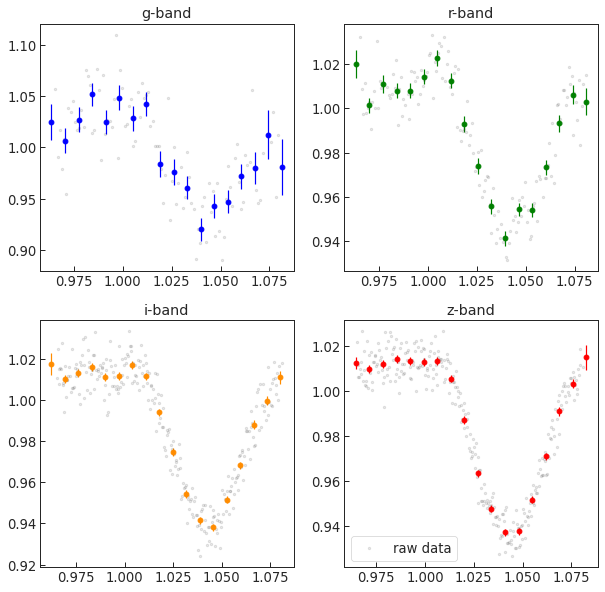

In [13]:
fig = lpf.plot_raw_data()

In [14]:
lpf.optimize_chi2_linear_baseline()

6048.90623319328 True [0.02440646 0.02069432 0.01792768 0.01656962]


array([0.02440646, 0.02069432, 0.01792768, 0.01656962])

In [15]:
p0 = lpf.model_params_vals
p0

[1.0465000001713634, 12.879247193048114, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 0, 0]

In [16]:
lpf.get_chi2_transit(p0)

49491.50485677837

## Optimization

In [17]:
i = 0
max_iter = 100 
while True:
    lpf.optimize_chi2_transit(p0)
    if lpf.opt_result.success:
        break
    if i>max_iter:
        print("Max iteration reached. Check input values.")
        break
    i+=1

Optimization successful!
---------------------
Optimized parameters:
tc: 1.04
a_Rs: 11.50
r1: 1.00
r2_g: 0.49
r2_r: 0.42
r2_i: 0.42
r2_z: 0.42
d_g: -0.00
d_r: -0.01
d_i: -0.00
d_z: -0.00


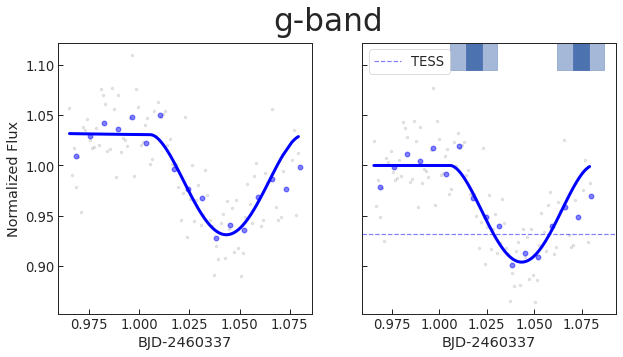

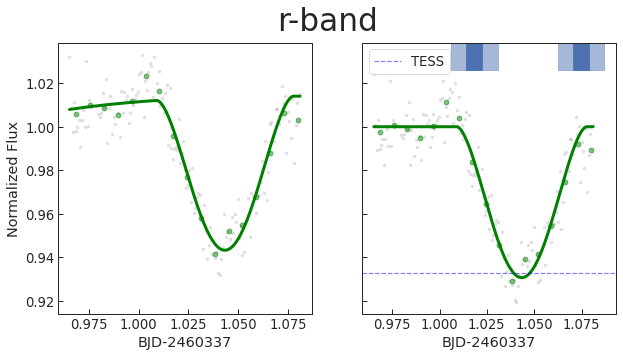

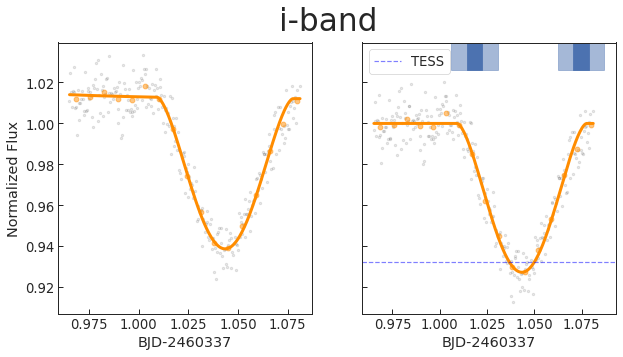

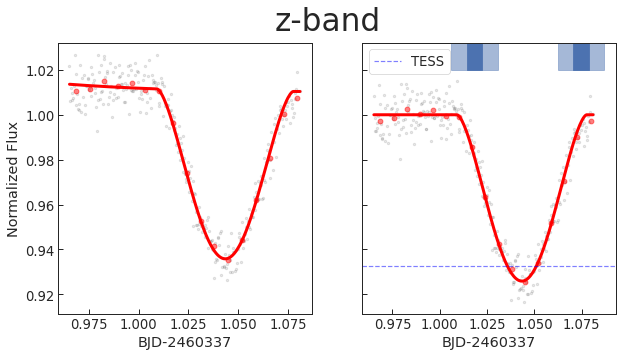

In [18]:
# using optimized parameters
pv = lpf.optimum_params
fig = lpf.plot_lightcurves(pv, figsize=(10,5))

## MCMC

In [19]:
lpf.sample_mcmc(nsteps=500)

100%|██████████| 500/500 [00:40<00:00, 12.48it/s]


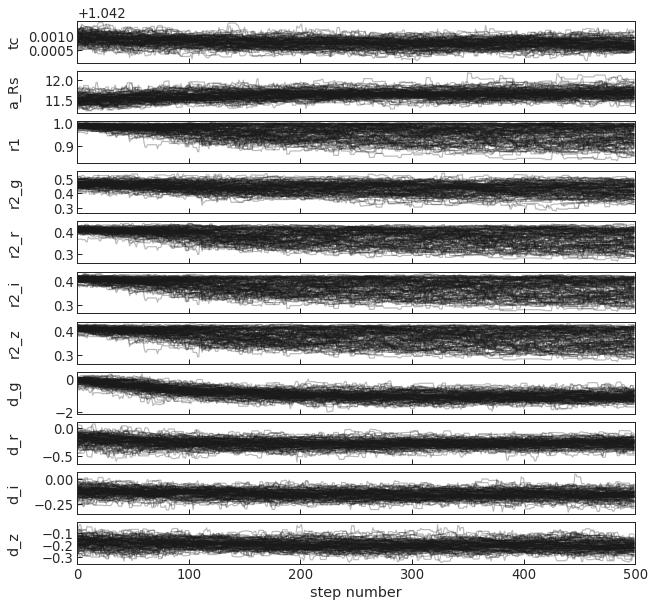

In [20]:
fig = lpf.plot_chain()

## Posteriors

In [21]:
df = lpf.get_mcmc_samples()
df.head()

Converting r1,r2 --> imp,k


,tc,a_Rs,imp,k_g,k_r,k_i,k_z,d_g,d_r,d_i,d_z
0,2.460338e+06,11.336931,0.982667,0.504201,0.413048,0.408594,0.410240,-0.111626,-0.160475,-0.209784,-0.152619
1,2.460338e+06,11.632356,0.991838,0.501280,0.414922,0.413204,0.419307,0.046958,-0.236780,0.000208,-0.124007
2,2.460338e+06,11.649567,0.988473,0.481434,0.422672,0.404534,0.411815,0.084994,-0.339140,-0.119254,-0.218803
3,2.460338e+06,11.481163,0.984113,0.448458,0.409373,0.406277,0.405629,-0.347040,-0.015759,-0.155563,-0.140217
4,2.460338e+06,11.576891,0.965262,0.474536,0.400282,0.393260,0.402443,-0.179394,-0.127594,-0.193579,-0.218795


In [22]:
if False:
    outfile = f'{lpf.outdir}/{lpf.model}_samples.csv.gz'
    df.to_csv(outfile, index=False)
    print("Saved: ", outfile)

Converting r1,r2 --> imp,k


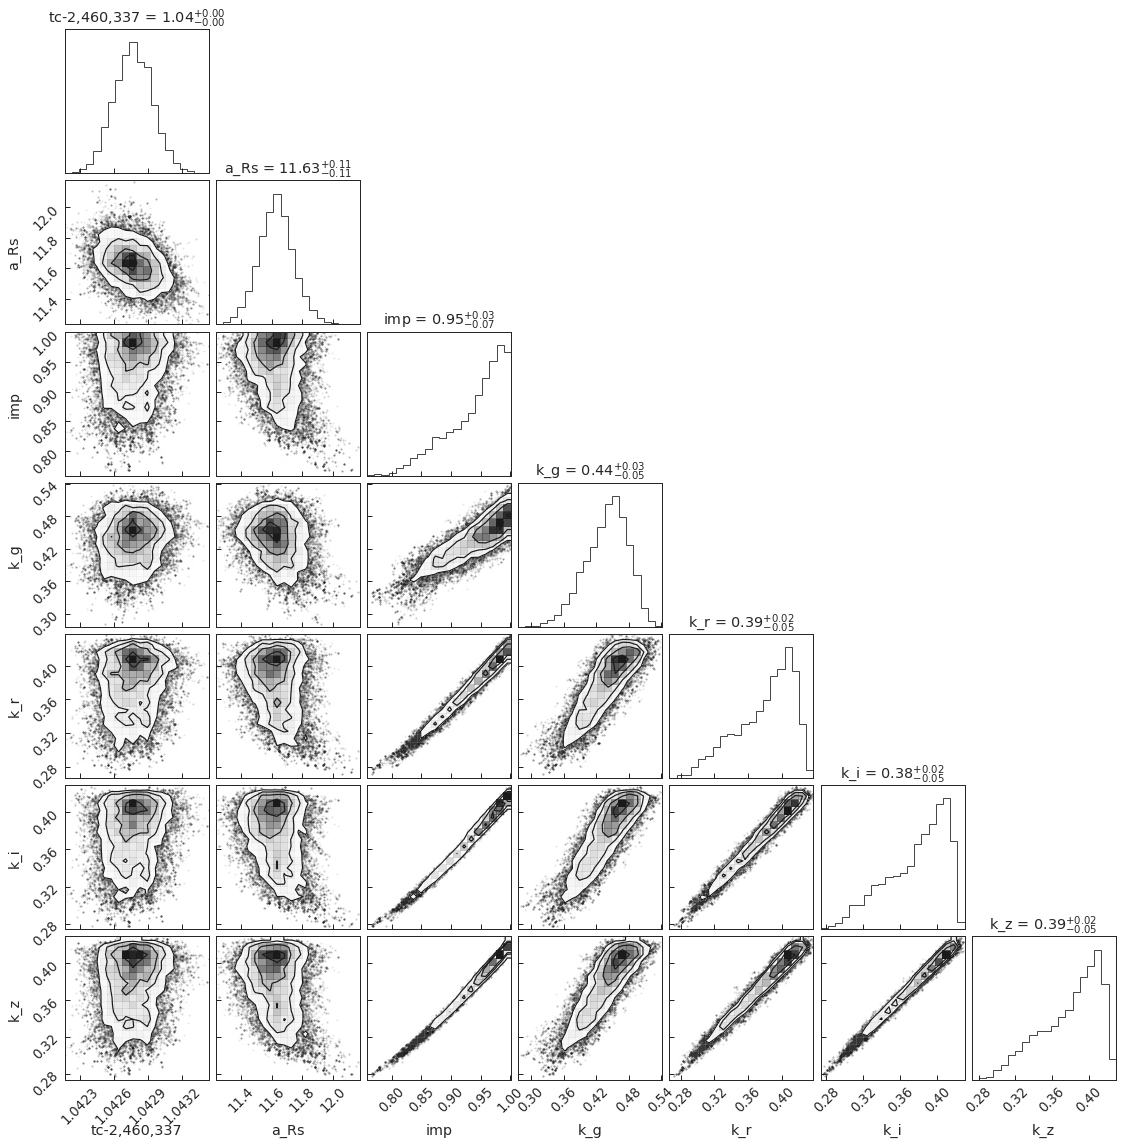

In [23]:
fig = lpf.plot_corner(start=0, end=7, transform=True)

if False:
    outfile = f"{lpf.outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_corner.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

Rp/Rs(g)^2 = 196.39 ppt
Rp/Rs(r)^2 = 150.51 ppt
Rp/Rs(i)^2 = 147.89 ppt
Rp/Rs(z)^2 = 149.70 ppt


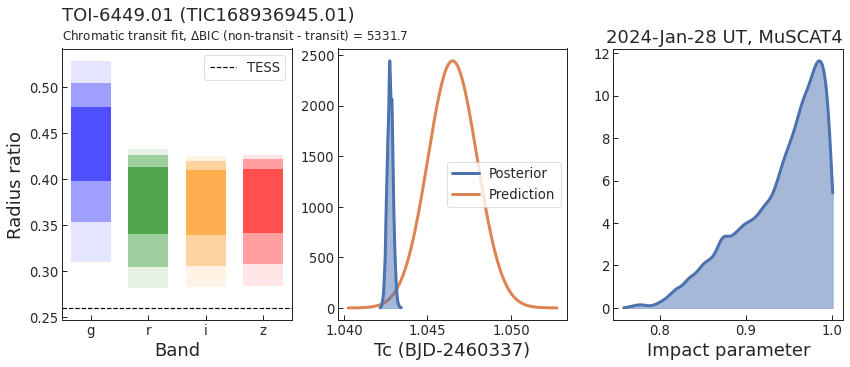

In [24]:
fig = lpf.plot_posteriors(nsigma=3, save=False, figsize=(14,5))

if False:
    outfile = f"{lpf.outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_posteriors.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

## Final fit

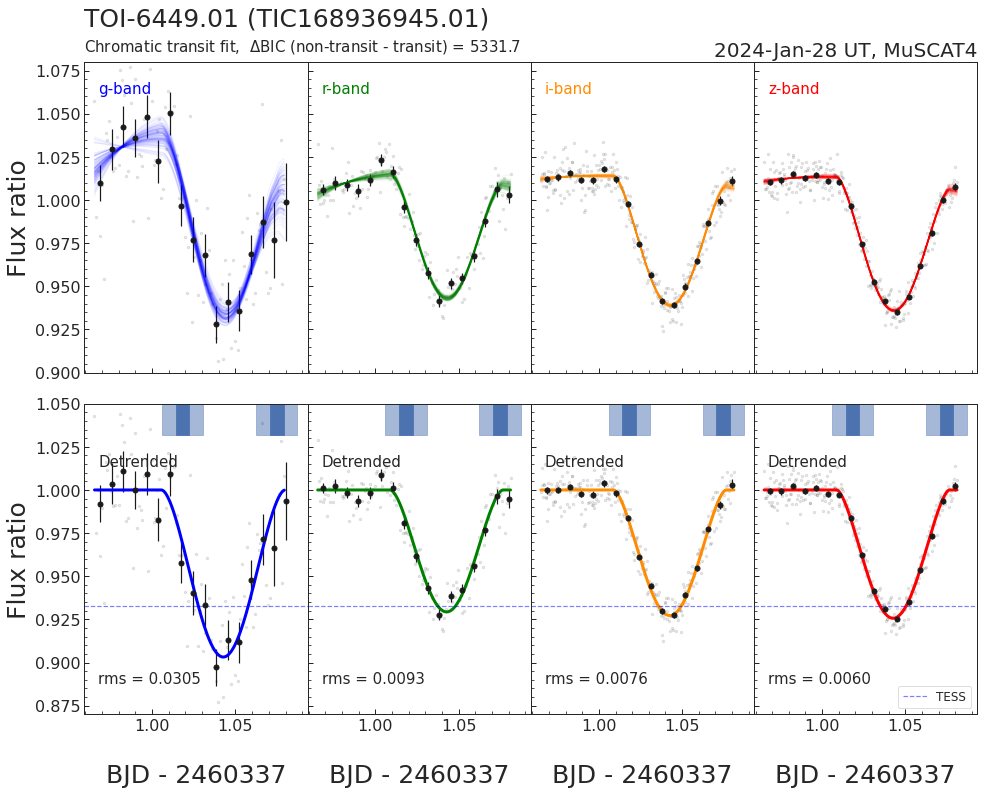

In [25]:
fig = lpf.plot_final_fit(ylims_top=(0.9,1.08),
                         ylims_bottom=(0.87,1.05), 
                         font_size=25,
                         save=False
                        )

if False:
    outfile = f"{lpf.outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_final_fit.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

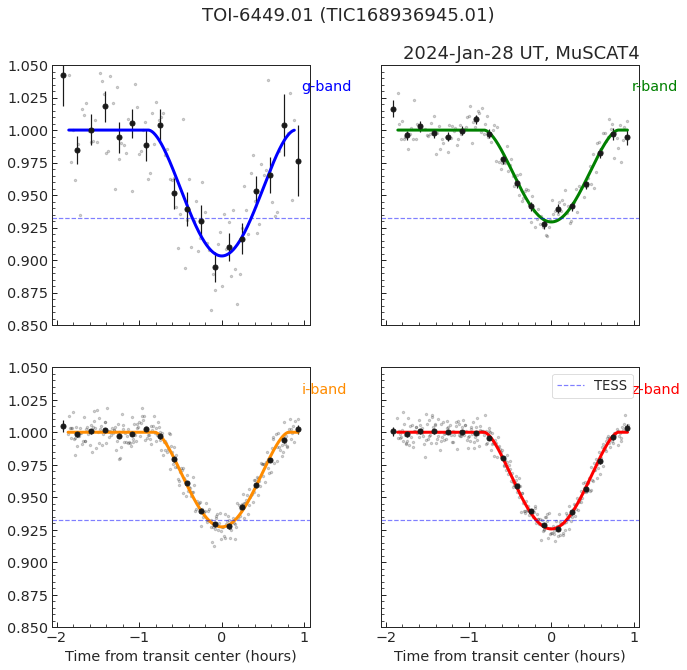

In [26]:
pv = lpf.best_fit_params
fig = lpf.plot_detrended_data_and_transit(pv, figsize=(10,10), 
                                          # xlims=(-1.3,1.3),
                                          ylims=(0.85, 1.05),
                                          title_height=0.95,
                                          font_size=18
                                         )

if False:
    outfile = f"{lpf.outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_models.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

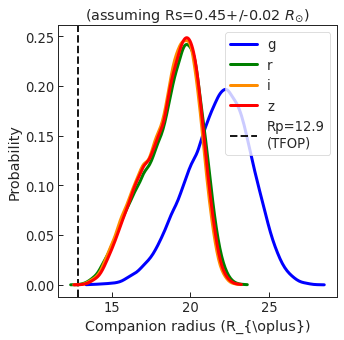

In [27]:
import astropy.units as u

fig = lpf.plot_radii(*star.rstar, unit=u.Rearth)

if False:
    outfile = f"{lpf.outdir}/{lpf.name}{lpf.alias}_{lpf.date}_{lpf.inst}_{''.join(lpf.bands)}_{lpf.model}_radii.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

In [28]:
print(lpf.get_report())

Title: TIC 168936945.01 (TOI 6449.01) on UT 20240128 from FTS-2m-MuSCAT4 in g,r,i,z

We observed a full/ingress/egress on 20240128 UT in g,r,i,z and detected a 5.4-min early (1.8 sigma), [Rp/Rs]^2: 196.4,150.5,147.9,149.7 ppt event using XXX" uncontaminated/contaminated aperture.

Typical FWHM: NA
Predicted Tc: 10338.046500 ± 0.002083 (+2450000) BJD_TDB
Measured Tc: 10338.042763 ± 0.000170 (+2450000) BJD_TDB
NEBcheck stars NOT cleared: NEBs not checked


## FOV

In [30]:
ls data

chromatic_samples.csv.gz
ref-coj2m002-ep07-20240128-0077-e91.fits
ref-coj2m002-ep07-20240128-0077-e91.objects
sample_TIC253864764-01_20240514_LCO-SAAO-1m0_zs_Observation-Notes.txt
sample_TIC941340744.01_20240118_MuSCAT4_notes.txt
sample_TOI-6251.01L-af20230722_MuSCAT3_notes.txt
TOI6449b-jd20240128_MuSCAT4_g_measurements.csv
TOI6449b-jd20240128_MuSCAT4_i_measurements.csv
TOI6449b-jd20240128_MuSCAT4_r_measurements.csv
TOI6449b-jd20240128_MuSCAT4_z_measurements.csv


In [31]:
ref_obj_file_path = './data/ref-coj2m002-ep07-20240128-0077-e91.objects'

In [32]:
best_cIDs = [4,5,7,8,9,10]
best_aper_pix = 22

ref = 'ref-coj2m002-ep09-20240128-0075-e91'

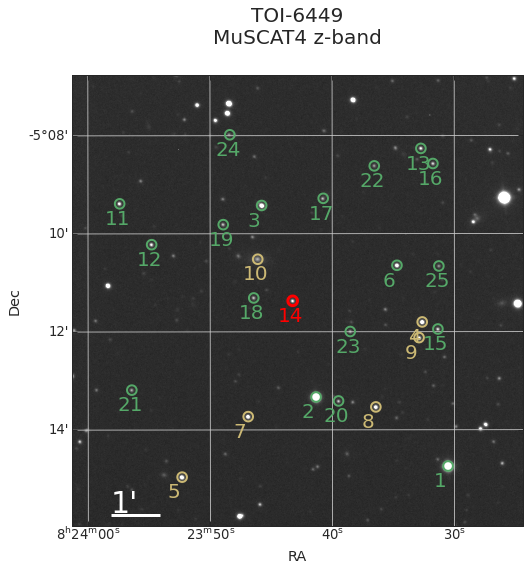

In [33]:
from aesthetic.plot import savefig

afphot_dir = f'/ut3/muscat/reduction_afphot/{lpf.inst.lower()}/{date}/{target}/reference'
ref_fits_file_path = f'{afphot_dir}/{ref}.fits'
ref_obj_file_path = f'{afphot_dir}/{ref}.objects'

fig = lpf.plot_fov(ref_fits_file_path, 
                   ref_obj_file_path,
                   phot_aper_pix=best_aper_pix,
                   cmap='gray',
                   contrast=0.1,
                   target_ID=14,
                   best_cIDs=best_cIDs,
                   cIDs_color='y',
                   marker_color='g',
                   text_offset=(0.005, -0.007),
                   scale_color='w',
                   font_size=20,
                   title_height=0.95
                  )
if False:
    outfile = f"{lpf.outdir}/{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_z_FOV.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

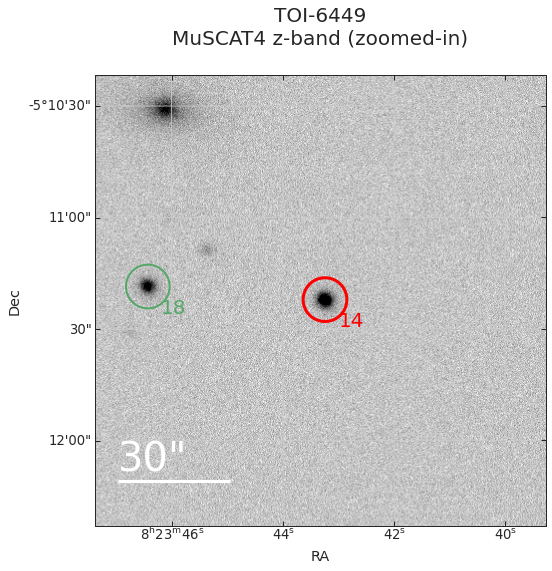

In [34]:
from aesthetic.plot import savefig

fig = lpf.plot_fov_zoom(ref_fits_file_path, 
                        ref_obj_file_path,
                        zoom_rad_arcsec=60,
                        bar_arcsec=30,
                        target_ID=14,
                        phot_aper_pix=best_aper_pix,
                        cmap='gray_r',
                        contrast=0.1,
                        marker_color='g',
                        text_offset=(-0.001, -0.002),
                        scale_color='w',
                        font_size=20,
                        title_height=0.95,
                  )
if False:
    outfile = f"{outdir}/{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_z_FOV_zoom.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

## Check for known variable sources in Simbad

Querying Simbad sources 300" around TOI-6449: (125.9305, -5.1895) deg.


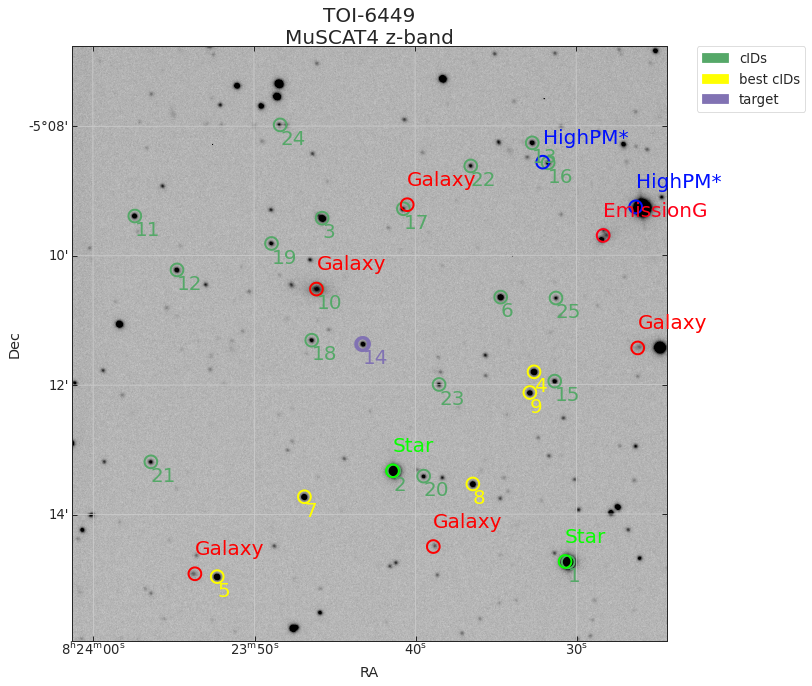

In [12]:
best_cIDs = [4,5,7,8,9]
best_aper_pix = 22

ref = 'ref-coj2m002-ep09-20240128-0075-e91'
afphot_dir = f'/ut3/muscat/reduction_afphot/{lpf.inst.lower()}/{date}/{target}/reference'
ref_fits_file_path = f'{afphot_dir}/{ref}.fits'
ref_obj_file_path = f'{afphot_dir}/{ref}.objects'

fig = lpf.plot_fov_simbad(ref_fits_file_path,
                          ref_obj_file_path,
                          cmap='gray_r',
                          contrast=0.2,
                          target_ID=14,                          
                          target_color='m',
                          phot_aper_pix=best_aper_pix,
                          best_cIDs=best_cIDs,
                          marker_color='g',
                          text_offset=(0,0.005),
                          fov_simbad_arcsec=5*60,
                          title_height=0.92
                         )

## Compare to Gaia

In [31]:
gaia_sources = star.get_gaia_sources(rad_arcsec=60)
gaia_sources.tail()

Querying Gaia sources 60" around TOI-6449: (125.9305, -5.1895) deg.


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,distance,distance_arcsec
5,1635721458409799680,Gaia DR2 3065970448725166592,3065970448725166592,1229802523,2015.5,125.943584,0.046124,-5.188518,0.035130,0.890090,...,0.0616,200111,0.729568,0.612295,0.832648,0.561501,0.484217,0.638786,0.786665,47.199900
6,1635721458409799680,Gaia DR2 3065970306992482304,3065970306992482304,1420012143,2015.5,125.919668,6.826816,-5.198015,4.014375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.822693,49.361581
7,1635721458409799680,Gaia DR2 3065970341350172160,3065970341350172160,1655416117,2015.5,125.944783,0.202826,-5.191909,0.156519,0.134663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.868291,52.097472
8,1635721458409799680,Gaia DR2 3065970306990616704,3065970306990616704,362959562,2015.5,125.930888,10.120919,-5.205093,15.193645,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.936199,56.171948
9,1635721458409799680,Gaia DR2 3065970306990648832,3065970306990648832,1545302146,2015.5,125.917792,0.756717,-5.199268,0.582386,-0.766882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.957266,57.435948


In [32]:
from astropy.io import fits
from glob import glob

fl = glob(f"/ut3/muscat/reduction_afphot/{lpf.inst.lower()}/{date}/{target}/reference/*.fits")
header = fits.getheader(fl[-1])
pixscale = header['pixscale']
pixscale

0.267

In [33]:
#distance to nearest stars in pix
gaia_sources["distance_arcsec"].head()/pixscale

0      0.000051
1    126.752936
2    147.341610
3    151.077080
4    175.694529
Name: distance_arcsec, dtype: float64

In [34]:
#aper radius in arcsec
best_aper_pix*pixscale

5.8740000000000006

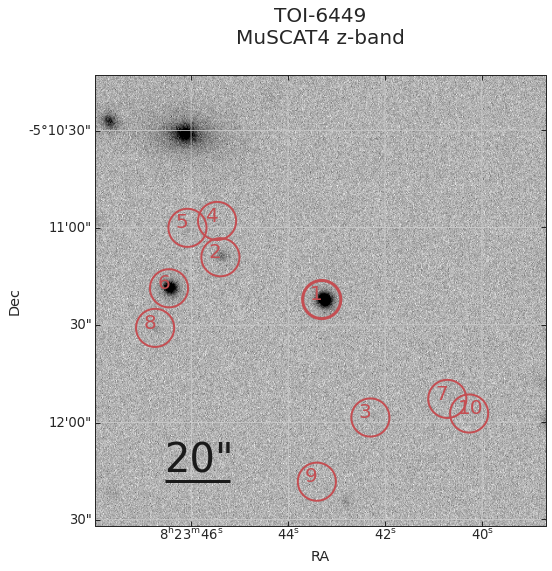

In [35]:
from aesthetic.plot import savefig

fig = lpf.plot_gaia_sources(ref_fits_file_path, 
                            gaia_sources, 
                            phot_aper_pix=best_aper_pix,
                            text_offset=(0.001, 0),
                            fov_padding=1.2,
                            cmap='gray_r',
                            contrast=0.1,
                            bar_arcsec=20,
                            marker_color='r',
                            scale_color='k',
                            font_size=20,
                            title_height=0.95,
                           )
if False:
    outfile = f"{lpf.outdir}/{lpf.name}{lpf.alias}_20{lpf.date}_{lpf.inst}_r_FOV_gaia_sources.pdf"
    savefig(fig, outfile, dpi=300, writepdf=False)

## Comparison of results

In [11]:
import pandas as pd
from corner import corner

df1 = pd.read_csv('muscat4/TOI-6449/tfop/chromatic_samples.csv.gz')
df2 = pd.read_csv('muscat4/TOI-6449/tfop_transform/chromatic_samples_transform.csv.gz')

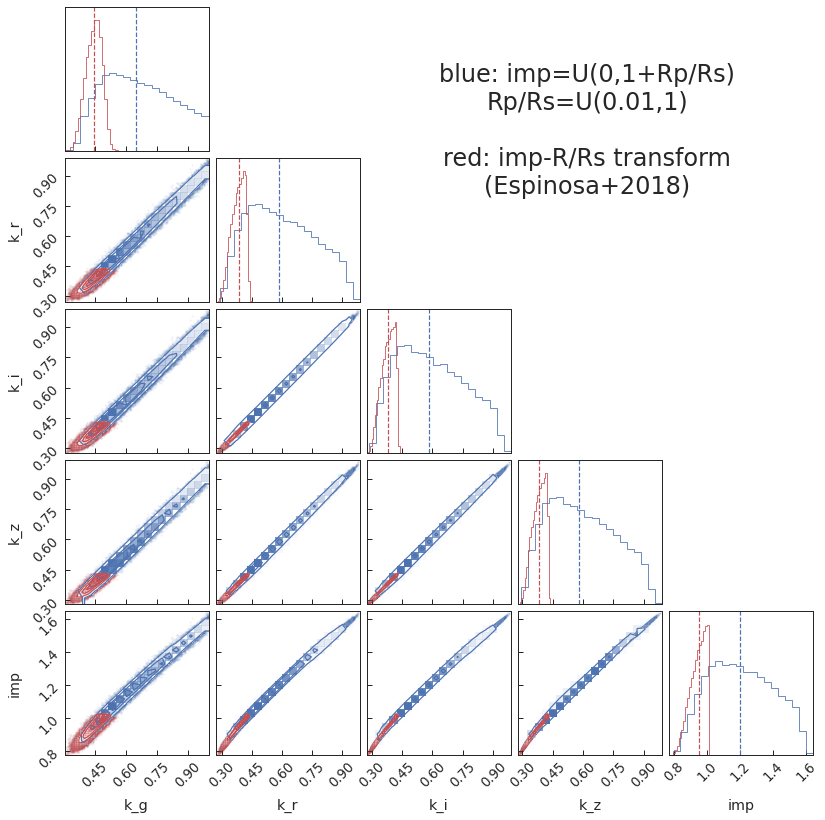

In [69]:
import numpy as np

cols = ['k_g','k_r','k_i','k_z','imp']
fig = corner(df1[cols], color='b', show_titles=False, quantiles=[0.5])
_ = corner(df2[cols], fig=fig, weights=np.ones(len(df2))*len(df1)/len(df2), quantiles=[0.5], color='r')
fig.suptitle(f"blue: imp=U(0,1+Rp/Rs)\nRp/Rs=U(0.01,1)\n\nred: imp-R/Rs transform\n(Espinosa+2018)", 
             y=0.9, x=0.7, fontsize=24);